# Example: Registered Interest and Principal of Securities (STRIPS) Bonds
This example will familiarize students with the ideas behind [Registered Interest and Principal of Securities (STRIPS)](https://www.treasurydirect.gov/marketable-securities/strips/) bonds. In particular, we will create a model for a random treasury note or bond with semi-annual coupon payments. Then, we will strip the coupon payments and face value to produce a collection of zero-coupon STRIPS bonds.

## Learning objectives
* __Prerequisite__: Load the Treasury auction dataset, which contains data from recent auctions or treasury bills, notes, and bonds
* __Objective 1__: Build a model for a treasury bond and strip the bond's coupon payments and face value.
    * `Check`: Are the calculated and observed auction prices `similar`?
    * `TODO`: Strip the note or bond model to create a collection of zero-coupon payments
        * `Check`: Do we have the correct number of stripped products?
* __Objective 2__: Explore pricing schemes for the stipped zero-coupon marketable securities created from the parent instrument
    * `TODO`: Constant yield pricing scheme for zero-coupon bond price and yield
        * `Check`: How much do we collect from the sale of the STRIPS?
        * `Summary` of the constant yield pricing scheme
    * `TODO`: Constant discount pricing scheme for zero-coupon bond price and yield
        * `Check`: How much do we collect from the sale of the STRIPS?
        * `Summary` of the constant discount pricing scheme

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material. 

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-3/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-3`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-3/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisite: Load the Treasury auction dataset
We'll explore `T-note` and `T-bond` prices from United States Treasury auctions between October 2022 and August 2023 downloaded as a `CSV` file using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). 
* We load the `CSV` dataset using the `MyTreasuryNotesAndBondsDataSet()` function, which returns the auction data as a `DataFrame`. We store the auction data in the `dataset`

In [2]:
dataset = MyTreasuryNotesAndBondsDataSet()

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,High Yield,Interest Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64,Float64
1,91282CHW4,Note,7-Year,08/29/2023,08/31/2023,08/31/2030,99.4773,0.04212,0.04125
2,91282CHV6,Note,2-Year,08/28/2023,08/31/2023,08/31/2025,99.9549,0.05024,0.05
3,91282CHX2,Note,5-Year,08/28/2023,08/31/2023,08/31/2028,99.8889,0.044,0.04375
4,912810TU2,Bond,20-Year,08/23/2023,08/31/2023,08/15/2043,98.3742,0.04499,0.04375
5,912810TT5,Bond,30-Year,08/10/2023,08/15/2023,08/15/2053,98.9127,0.04189,0.04125
6,91282CHT1,Note,10-Year,08/09/2023,08/15/2023,08/15/2033,98.9862,0.03999,0.03875
7,91282CHU8,Note,3-Year,08/08/2023,08/15/2023,08/15/2026,99.936,0.04398,0.04375
8,91282CHR5,Note,7-Year,07/27/2023,07/31/2023,07/31/2030,99.475,0.04087,0.04
9,91282CHQ7,Note,5-Year,07/25/2023,07/31/2023,07/31/2028,99.7988,0.0417,0.04125


## Objective 1: Select a random note or bond from which we create separate marketable products
We'll select a random note or bond, compute its price, compare it to the auction price (to `check` our price codes), and then `strip` the selected note or bond.
* First, let's determine how many notes and bonds we have in the `dataset` using the [nrow function](https://dataframes.juliadata.org/stable/lib/functions/#DataAPI.nrow) that is exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl). Then, we compute a random index using the [built-in Julia rand function](https://docs.julialang.org/en/v1/stdlib/Random/). We store the data for the random note or bond in the `random_note_or_bond` variable

In [3]:
number_of_notes_and_bonds = nrow(dataset)
random_note_or_bond = dataset[rand(1:number_of_notes_and_bonds),:]
# ridx = 49;
# random_note_or_bond = dataset[ridx,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,High Yield,Interest Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64,Float64
32,91282CGQ8,Note,7-Year,02/23/2023,02/28/2023,02/28/2030,99.6255,0.04062,0.04


Get the parameters from `random_note_or_bond` variable to test our price calculation. 
* In particular, we set the face (par) value `Vₚ,` the duration `T` (which we convert to the number of years using the `securityterm` function), the yield field, i.e., the $\bar{r}$ value in the discount rate, the coupon rate $c$ and the number of coupon payments per year `λ`.

In [4]:
Vₚ = 100.0; # face value of the note or bond
T = random_note_or_bond[Symbol("Security Term")] |> String |> securityterm; # term as a Float64
r̄ = random_note_or_bond[Symbol("High Yield")]; # Effective discount rate
c = random_note_or_bond[Symbol("Interest Rate")]; # Interest rate (coupon rate)
λ = 2; # number of coupon payments per year

Next, we instantiate a discrete compounding model, and store this model in the `discrete_compounding` variable:

In [5]:
# Build a discrete compounding model -
discrete_compounding = DiscreteCompoundingModel();

Finally,  compute the price of the note (or bond) using the short-cut syntax and the discount model. We store the populated note or bond in the `model` variable, and the computed price in the `nominal_computed_price` (the `price` field on the `model`):

In [6]:
# Build a T-year model and compute the price using the short-hand syntax
model = build(MyUSTreasuryCouponSecurityModel, (
            par = Vₚ, T = T, rate = r̄, coupon = c, λ = λ
        )) |> discrete_compounding;

nominal_computed_price = model.price;

### Check: Are the calculated and observed auction prices `similar`?
Use the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) combined with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check the `similarity` of the computed, and observed note (or bond) price. If the price values are different beyond `rtol = 1e-3`, a `false` result is generated, and an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown.

In [7]:
observed_bond_price = random_note_or_bond[:Price];
@assert isapprox(observed_bond_price, nominal_computed_price; rtol = 1e-3)

### TODO: Strip the note or bond to create a collection of zero-coupon payments
We generate a dictionary of zero-coupon bond models for a `MyUSTreasuryCouponSecurityModel` using the `strip(...)` function exported by the [VLQuantitativeFinancePackage.jl package](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) 
* The resulting `strips` dictionary stores the generated bonds in order of duration, with their indexes serving as keys and the corresponding `MyUSTreasuryZeroCouponBondModel` instances as values. 

In [8]:
strips = VLQuantitativeFinancePackage.strip(model);

#### Check: Do we have the correct number of stripped products?
For a parent note or bond of duration `T` years, there should be $\lambda\cdot{T}+1$ STRIPS, where $\lambda$ is the number of coupon payments per year. Let's verify that `strip(...)` function produced the correct number of products. 
* Use the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check the number of STRIPS. If the `incorrect` number of products is in the `strips` dictionary, a `false` result is generated, and an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown.

In [9]:
number_of_strips = λ*T+1 |> Int # correct number of STRIPs
@assert length(strips) == number_of_strips

## Objective 2: Pricing the STRIPS products for secondary auction
STRIPS are sold at a discount compared to their face. However, it’s important to note that the secondary seller, i.e., the brokerage splitting the original note or bond, determines the discount in the secondary treasury market. To better understand this, let’s propose two hypothetical pricing schemes that a brokerage might employ:

* __Scheme 1 constant yield__: In this approach, the brokerage prices the zero-coupon instruments to have a constant yield $\bar{r}$. This can be achieved by setting the price as an escalating fraction of the par value $V_{B} = \left(\alpha\right)^{T}\cdot{V}_{P}$, where $\alpha\leq{1}$, and $T$ represent the time to maturity of the generated zero coupon bond.

* __Scheme 2 constant discount__: The brokerage prices the zero-coupon instruments to have a constant discount, i.e., the ratio of price to face value is constant across all instruments. In this case, $V_{B} = \left(\alpha\right)\cdot{V}_{P}$ is not a function of the time to maturity of the instrument, and $\alpha\leq{1}$.

### TODO: Constant yield (Scheme 1) STRIPS bond price and yield
To start, let's specify a value for the escalation parameter $\alpha\leq{1}$:

In [10]:
α = 0.97; # must be less than 1

Next, for each `zero` in the `strips` dictionary, let's specify (or compute) the missing `price` and `rate` values. 
* To compute the price value, we compute the discount `d` (which depends upon our choice of `scheme` and $\alpha$) and the `yield` using the `YTM(...)` function exported by the [VLQuantitativeFinancePackage.jl package](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [11]:
for i ∈ 1:number_of_strips

    # get data from this strip
    model = strips[i];
    T = model.T
    Vₚ = model.par;
    
    # compute the discount d
    d = (α)^T; # we selected scheme 1
    
    # set the price
    model.price = (d)*Vₚ
    
    # do a YTM calculation to compute the market rate of interest
    model.rate = VLQuantitativeFinancePackage.YTM(model, discrete_compounding)
end

#### Visualize the first $m$ STRIPS products
`Unhide` the next code cell to see how we build a table displaying the bond price information. 
* First, specify the `number_of_strips_to_view.` Then, we'll loop through each STRIP and access the respective models from the `strips` dictionary using the bracket notation `strips[i],` where `i` represents the STRIP index. 
* Next, we'll add pricing, maturity, etc. data to the `strips_table_data_array` and display the resulting table by calling the `pretty_table(…)` function, which is exported by the [PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl)

In [19]:
number_of_strips_to_view = number_of_strips ≥ 10 ? 10 : number_of_strips
strips_table_data_array_S1 = Array{Any,2}(undef, number_of_strips, 6);
strips_table_header_array = (["", "Maturity","Face","Price","r̄", "Discount"],
    ["","YR","USD","USD","", "price/face"]);
for i ∈ 1:number_of_strips

    zc_model = strips[i];
    strips_table_data_array_S1[i,1] = i
    strips_table_data_array_S1[i,2] = zc_model.T
    strips_table_data_array_S1[i,3] = zc_model.par
    strips_table_data_array_S1[i,4] = zc_model.price
    strips_table_data_array_S1[i,5] = zc_model.rate  
    strips_table_data_array_S1[i,6] = (zc_model.price/zc_model.par)
end
pretty_table(strips_table_data_array_S1[1:number_of_strips_to_view,1:end], 
    header=strips_table_header_array, tf = tf_simple)

===== ========== ====== ======= ============ =============
       Maturity   Face   Price            r̄     Discount 
             YR    USD     USD                price/face 
===== ========== ====== ======= ============ =============
   1        0.5    2.0    1.94    0.0628122         0.97
   2        1.0    2.0    1.94    0.0309278         0.97
   3        1.5    2.0    1.94    0.0205137         0.97
   4        2.0    2.0    1.94    0.0153462         0.97
   5        2.5    2.0    1.94    0.0122582         0.97
   6        3.0    2.0    1.94    0.0102048         0.97
   7        3.5    2.0    1.94   0.00874061         0.97
   8        4.0    2.0    1.94   0.00764387         0.97
   9        4.5    2.0    1.94   0.00679167         0.97
  10        5.0    2.0    1.94   0.00611043         0.97
===== ========== ====== ======= ============ =============


#### Check: Visualize the yield curve for `scheme 1`
`Unhide` the next code cell to see how we plotted the yield curve suggested by your choice of the $\alpha$ parameter.

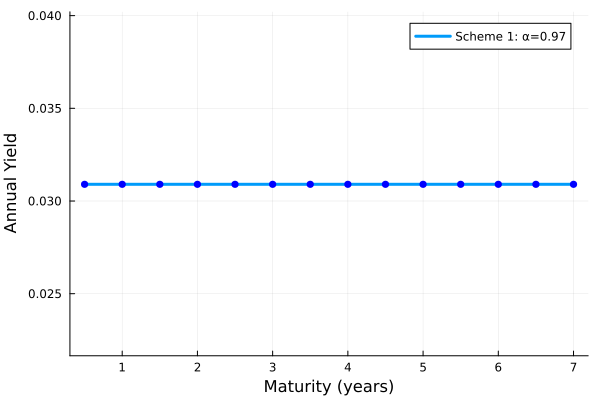

In [13]:
plot(strips_table_data_array_[1:end-1,2], round.(strips_table_data_array[1:end-1,5], digits=4),lw=3,
    label="Scheme 1: α=$(α)", ylims=(0.70*strips_table_data_array[1,5], 1.3*strips_table_data_array[1,5]))
scatter!(strips_table_data_array[1:end-1,2], round.(strips_table_data_array[1:end-1,5], digits=4), 
label="", msc="blue", mc="blue")
xlabel!("Maturity (years)",fontsize=18)
ylabel!("Annual Yield", fontsize=18)

#### Check: How much do we collect from the sale of the STRIPS?
In this scenario, we purchased an original instrument from the [United States Treasury](https://www.treasurydirect.gov/) for $V_{B}$, stripped the coupons and face, and resold them. How much did we make from the sale of the STRIPS?

In [14]:
resale_total = sum(strips_table_data_array[:,4]);
println("Purchased bond $(number_of_notes_and_bonds) for $(nominal_computed_price) USD and stripped it for $(resale_total) USD")

Purchased bond 59 for 99.62552378402029 USD and stripped it for 105.82305823064031 USD


#### Summary Scheme 1 Pricing
* The constant yield (Scheme 1) pricing approach gives a constant yield curve and a decreasing discount. The short maturity `zeros` are more expensive relative to the face value of the original instrument.
* The observed yield $\bar{r}$ is inversely proportional to the value of the escalation parameter $\alpha$; smaller values of $\alpha$ lead to higher yields $\bar{r}$. On the other hand, $\alpha$ is directly proportional to the discount, i.e., the price of the `zero` relative to its face value
* The yield we collect from the U.S. Treasury is always greater than what we pay to holders of the STRIPS products. Thus, we pay for the original instrument under pricing scheme 1. However, would anyone buy these STRIPS?

### TODO: Constant discount (Scheme 2) STRIPS bond price and yield
Now, let's consider scheme 2, which has a constant discount, i.e., the ratio of the auction price to the instrument's face value is constant. 
* We'll use the same value of escalation parameter $\alpha$ and procedure as the previous Scheme 1 calculation, except we remove the time dependence on the `d` variable

In [15]:
for i ∈ 1:number_of_strips

    # get data from this strip
    model = strips[i];
    T = model.T
    Vₚ = model.par;
    
    # compute the discount d
    d = (α); # we selected scheme 2
    
    # set the price
    model.price = (d)*Vₚ
    
    # do a YTM calculation to compute the market rate of interest
    model.rate = VLQuantitativeFinancePackage.YTM(model, discrete_compounding)
end

#### Visualize the first $m$ STRIPS products
`Unhide` the next code cell to see how we build a table displaying the bond price information. 
* First, specify the `number_of_strips_to_view.` Then, we'll loop through each STRIP and access the respective models from the `strips` dictionary using the bracket notation `strips[i],` where `i` represents the STRIP index. 
* Next, we'll add pricing, maturity, etc. data to the `strips_table_data_array` and display the resulting table by calling the `pretty_table(…)` function, which is exported by the [PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl)

In [16]:
number_of_strips_to_view = number_of_strips ≥ 10 ? 10 : number_of_strips
strips_table_data_array = Array{Any,2}(undef, number_of_strips, 6);
strips_table_header_array = (["", "Maturity","Face","Price","r̄", "Discount"],
    ["","YR","USD","USD","", "price/face"]);
for i ∈ 1:number_of_strips

    zc_model = strips[i];
    strips_table_data_array[i,1] = i
    strips_table_data_array[i,2] = zc_model.T
    strips_table_data_array[i,3] = zc_model.par
    strips_table_data_array[i,4] = zc_model.price
    strips_table_data_array[i,5] = zc_model.rate  
    strips_table_data_array[i,6] = (zc_model.price/zc_model.par)
end
pretty_table(strips_table_data_array[1:number_of_strips_to_view,1:end], 
    header=strips_table_header_array, tf = tf_simple)

===== ========== ====== ======= ============ =============
       Maturity   Face   Price            r̄     Discount 
             YR    USD     USD                price/face 
===== ========== ====== ======= ============ =============
   1        0.5    2.0    1.94    0.0628122         0.97
   2        1.0    2.0    1.94    0.0309278         0.97
   3        1.5    2.0    1.94    0.0205137         0.97
   4        2.0    2.0    1.94    0.0153462         0.97
   5        2.5    2.0    1.94    0.0122582         0.97
   6        3.0    2.0    1.94    0.0102048         0.97
   7        3.5    2.0    1.94   0.00874061         0.97
   8        4.0    2.0    1.94   0.00764387         0.97
   9        4.5    2.0    1.94   0.00679167         0.97
  10        5.0    2.0    1.94   0.00611043         0.97
===== ========== ====== ======= ============ =============


#### Check: Visualize the yield curve for `scheme 2`
`Unhide` the next code cell to see how we plotted the yield curve suggested by your choice of the $\alpha$ parameter.

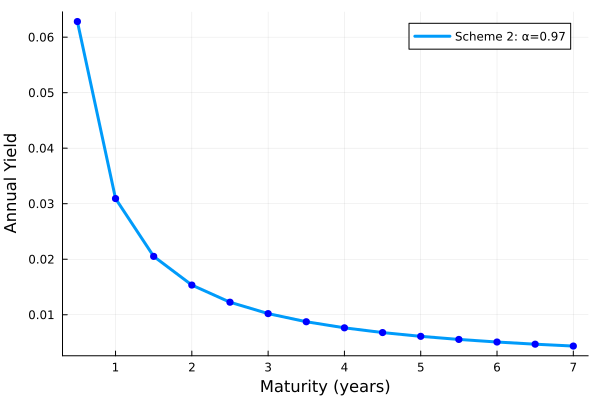

In [17]:
plot(strips_table_data_array[1:end-1,2], strips_table_data_array[1:end-1,5],lw=3,
    label="Scheme 2: α=$(α)")
scatter!(strips_table_data_array[1:end-1,2], strips_table_data_array[1:end-1,5], 
label="", msc="blue", mc="blue")
xlabel!("Maturity (years)",fontsize=18)
ylabel!("Annual Yield", fontsize=18)

#### Check: How much do we collect from the sale of the STRIPS?
In this scenario, we purchased an original instrument from the [United States Treasury](https://www.treasurydirect.gov/) for $V_{B}$, stripped the coupons and face, and resold them. How much did we make from the sale of the resale of the STRIPS?

In [18]:
resale_total = sum(strips_table_data_array[:,4]);
println("Purchased bond $(number_of_notes_and_bonds) for $(nominal_computed_price) USD and stripped it for $(resale_total) USD")

Purchased bond 59 for 99.62552378402029 USD and stripped it for 124.16 USD


#### Summary Scheme 2 Pricing
* The constant discount (Scheme 2) pricing approach gives an inverted yield curve. Under pricing scheme 2, short-maturity `zeros` yield more than longer-maturity bonds.
* The observed yield $\bar{r}$ is inversely proportional to the value of the escalation parameter $\alpha$; smaller values of $\alpha$ lead to higher yields $\bar{r}$. On the other hand, under this scheme, the discount is constant.
* The yield we collect from the U.S. Treasury is less than what we pay to holders of the STRIPS products for short-maturity products. However, we pay significantly less than the Treasury for longer-duration products. 

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.